This notebook will show how to deal with imbalance problems.

# 1. Set up

# 2. Import necessary libraries

In [41]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks, RandomUnderSampler

# 3. Define global variables

In [2]:
INPUT_PATH = "../data/credit_card_data/creditcard.csv"

# 4. Functions

# 5. Code

We are going to work with an imbalance problem in order to see how imbalance is such a common problem and what can we do in order to solve it and make a good predictive model.

First of all, we need to load some data. We are going to use the credit card fraud dataset that can be found in *kaggle*, https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud?resource=download

In [3]:
data = pd.read_csv(INPUT_PATH)

data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


This time we are not going to focus on the variables and so on because the main goal here is to see the imbalance problem and how to solve it. 

Let's see then if the problem is imbalanced:

In [4]:
class_counts = pd.DataFrame(data["Class"].value_counts(normalize=True))

class_counts

,Class
0,0.998273
1,0.001727


If we show it in a plot:

(0.0, 1.1)

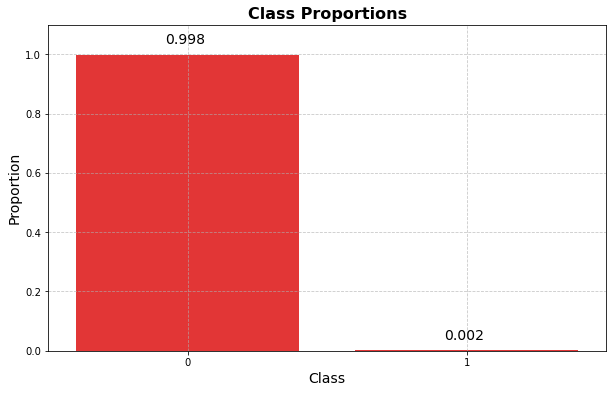

In [5]:
plt.figure(figsize=(10, 6)) 

# Barplot
ax = sns.barplot(x=class_counts.index, y='Class', data=class_counts, color="red",alpha=0.9)

# Indicate the proportion over the bars
for p in ax.patches:
    ax.annotate(f'{round(p.get_height(), 3)}', 
                # We need to set the numbers in the middle of each bar
                (p.get_x() + p.get_width()/2.5, p.get_height()+0.02), 
                fontsize=14,  
                xytext=(0, 5), 
                textcoords='offset points')

# Title and axis
plt.title('Class Proportions', fontsize=16, fontweight='bold')
plt.xlabel('Class', fontsize=14)
plt.ylabel('Proportion', fontsize=14)

# Set the grid
plt.grid(True, linestyle='--', alpha=0.7)

# Set the y limit to 1.1 in order to see better the numbers over the bar
plt.ylim(0, 1.1)

Clearly, the imbalance can be seen as the positive class is very little compared to the negative class.

## 5.1. Baseline

Now we are going to make a simple model, without touching any configuration nor any data processing. The model will be a bad model due to the imbalance problem. We are going to see what problems can be faced when dealing with this situation

First, train test split:

In [6]:
X = data.drop("Class", axis=1)
y = data["Class"]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

We will train a logistic regression:

In [8]:
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

/Users/aitor/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [9]:
y_pred = model.predict(X_test)

<AxesSubplot:>

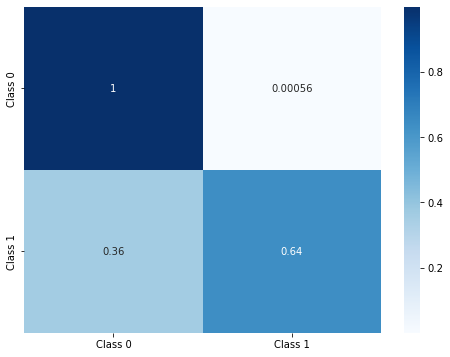

In [10]:
cm = confusion_matrix(y_test, y_pred, normalize="true")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])

In [11]:
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))


Accuracy Score: 0.9988623915058565


As observed, the model does not detect well those Class 1 data points. In fact, it only gets the 64% of the positives. We are going to try to better the situation by applying *oversampling* and *undersampling*.

## 5.2. Oversampling

Let's remember that oversampling is no more than creating synthetic data in the minority class. We are going to do it making use of the SMOTE algorithm.

I will set a little sampling_strategy. This is just a personal decision, you can modify the number the way you want. Mi decision goes with the next idea:

Our dataset contains only 0.2% of minority class. Thus, since we are "guessing" new data points, I will no go further than this 0.2%. I don't see the point in creating a false scenario where I set the minority class to the 20% for example. Again, personal opinion here.

In [19]:
smote = SMOTE(random_state=42, sampling_strategy=0.004)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

Let's compare the difference now between before and after:

In [33]:
print("Before SMOTE Oversampling:\n", y_train.value_counts(normalize=True))

print("*****"*8)

print("After SMOTE Oversampling:\n", y_smote.value_counts(normalize=True))

Before SMOTE Oversampling:
 0    0.998226
1    0.001774
Name: Class, dtype: float64
****************************************
After SMOTE Oversampling:
 0    0.995025
1    0.004975
Name: Class, dtype: float64


As observed, the minority class has increased. Thus, the model will detect better those patterns inside the minority class and will be able to apply those patterns to the test data. Let's go for it.

In [29]:
model = LogisticRegression(random_state=42)
model.fit(X_smote, y_smote)

/Users/aitor/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [30]:
y_pred = model.predict(X_test)

<AxesSubplot:>

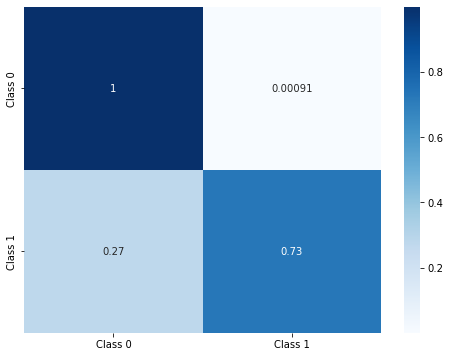

In [31]:
cm = confusion_matrix(y_test, y_pred, normalize="true")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])

The result has improved. Now we detect the 73% of the positives correctly, whereas before we were detecting the 64%.

## 5.3. Undersampling

Now, undersampling is going to be applied and the we will see which result is better for this data. We will use Tomek algorithm.

In [36]:
tomek = TomekLinks(sampling_strategy="majority")
X_tomek, y_tomek = tomek.fit_resample(X_train, y_train)

In [37]:
print("Before Tomek Undersampling:\n", y_train.value_counts(normalize=True))

print("*****"*8)

print("After Tomek Undersampling:\n", y_tomek.value_counts(normalize=True))

Before Tomek Undersampling:
 0    0.998226
1    0.001774
Name: Class, dtype: float64
****************************************
After Tomek Undersampling:
 0    0.998225
1    0.001775
Name: Class, dtype: float64


Since Tomek has barely modified the dataset, let's try another approach. This time the random undersampler.

In [57]:
rus = RandomUnderSampler(random_state=42, sampling_strategy=0.03)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

In [58]:
print("Before RandomUndersampler Undersampling:\n", y_train.value_counts(normalize=True))

print("*****"*8)

print("After RandomUndersampler Undersampling:\n", y_resampled.value_counts(normalize=True))

Before RandomUndersampler Undersampling:
 0    0.998226
1    0.001774
Name: Class, dtype: float64
****************************************
After RandomUndersampler Undersampling:
 0    0.970873
1    0.029127
Name: Class, dtype: float64


In [59]:
model = LogisticRegression(random_state=42)
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=42)

In [60]:
y_pred = model.predict(X_test)

<AxesSubplot:>

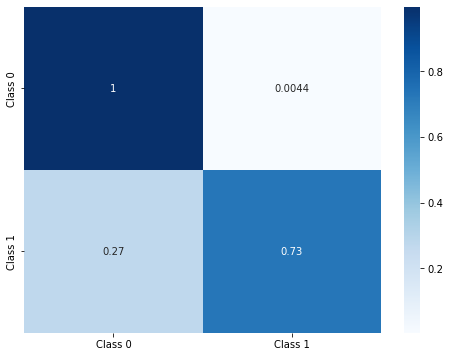

In [61]:
cm = confusion_matrix(y_test, y_pred, normalize="true")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])

It seems that the result is similar to the one obtained before.

# 6. Conclusions

We have seen how to apply methods like oversampling and undersampling when we have a balance problem in our data. However, it has to be taken with caution because we are "modifying" the reality. 